In [1]:
import numpy as np
from matplotlib import pyplot as plt
from symmer import PauliwordOp
from symmer.evolution import VQE_Driver
from symmer.process_handler import process; process.method='mp'
from utils.ansatze import ansatz_9
from utils.postprocessing import noise_amplification_factors

with open(f'data/raw_measurements/N2_vqe_results_9.txt', 'r') as f:
    from qiskit_ibm_runtime import RuntimeDecoder
    decoder = RuntimeDecoder()
    data_in = decoder.decode(f.read())
    vqe_result = data_in['result']
    vqe_inputs = data_in['inputs']
    zne_degree = data_in['zne_degree']
    use_depth  = data_in['calibrate_by_depth']

/Users/timw/anaconda3/envs/N2env/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [4]:
H = PauliwordOp.empty(5)
for clique in vqe_inputs['QWC_cliques'].values():
    labels = clique.primitive.paulis.to_labels()
    coeffs = clique.coeffs
    H += PauliwordOp.from_list(labels, coeffs)

vqe = VQE_Driver(observable=H, ansatz_circuit=ansatz_9())
noiseless_vqe_result, noiseless_vqe_interim = vqe.run()
X_noiseless_energies, Y_noiseless_energies = zip(*noiseless_vqe_interim['energy'].items())
X_noiseless_gradient, Y_noiseless_gradient = zip(*noiseless_vqe_interim['gradient'].items())
Y_noiseless_energies = np.array(Y_noiseless_energies)
Y_noiseless_gradient = np.linalg.norm(Y_noiseless_gradient, axis=1, ord=1)
X_noiseless_energies = list(map(int, X_noiseless_energies))
X_noiseless_gradient = list(map(int, X_noiseless_gradient))

VQE simulation commencing...

Optimization step 0 :
	 Energy = -106.98709841012706


	    |∆| = 0.4194278499014366
Optimization step 1 :
	 Energy = -107.1065362120892
	    |∆| = 0.38102275665510493
Optimization step 2 :
	 Energy = -107.35610209547416
	    |∆| = 0.14687411695467673
Optimization step 3 :
	 Energy = -107.37204365181474
	    |∆| = 0.1279829319731946
Optimization step 4 :
	 Energy = -107.39039353496804
	    |∆| = 0.10191753136244547
Optimization step 5 :
	 Energy = -107.40335660077253
	    |∆| = 0.1143189633778332
Optimization step 6 :
	 Energy = -107.40973895757432
	    |∆| = 0.0911095201734228
Optimization step 7 :
	 Energy = -107.41726829408535
	    |∆| = 0.06239879018758662
Optimization step 8 :
	 Energy = -107.42343192007812
	    |∆| = 0.023973596941810234
Optimization step 9 :
	 Energy = -107.42405240955111
	    |∆| = 0.018761543540397323
Optimization step 10:
	 Energy = -107.4245047242088
	    |∆| = 0.013238364254145416
Optimization step 11:
	 Energy = -107.42470496813219
	    |∆| = 0.00878429216953378
Optimization step 12:
	 Energy = -107.4247992350

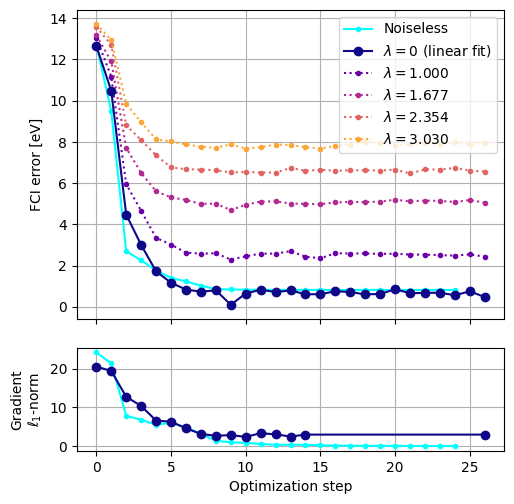

In [6]:
FCI_energy = -107.45515559770585
ev_unit = 27.2114
deg = 1
fitstr = 'Linear'
nf = noise_amplification_factors(vqe_result)

X_grad, Y_grad = zip(*vqe_result['VQE_data']['gradient_history']['values'].items())
Y_grad_norm = np.linalg.norm(Y_grad, axis=1, ord=1)
X_energy, Y_energy = zip(*vqe_result['VQE_data']['energy_history']['values'].items())
X_energy = np.array(list(map(int,X_energy)))
Y_energy = np.array([
    vqe_result['VQE_data']['energy_history']['data'][str(i)]['data_for_extrapolation']
    for i in X_energy
]).T
w = 1/np.std(Y_energy[:,4:], axis=1)
Y_extrapolated = np.array([np.polyfit(nf, y, deg=deg, w=w)[-1] for y in Y_energy.T])
grad_norm = np.linalg.norm(Y_grad, ord=1, axis=1)
fig, axes = plt.subplots(2,1,figsize=(5,5),sharex=True,gridspec_kw={'height_ratios':(3,1)})
fig.tight_layout()
axes[0].plot(X_noiseless_energies, (Y_noiseless_energies-FCI_energy)*ev_unit, 
    marker='.', label='Noiseless', color='cyan')
axes[1].plot(X_noiseless_gradient, Y_noiseless_gradient*ev_unit, marker='.', color='cyan')
axes[0].plot(X_energy, (Y_extrapolated-FCI_energy)*ev_unit, color=plt.cm.plasma(0), 
    label=f'$\\lambda=0$ ({fitstr.lower()} fit)', marker='o',zorder=100)
for i,y in enumerate(Y_energy):
    c = plt.cm.plasma((i+1)/5)
    axes[0].plot(X_energy, (y-FCI_energy)*ev_unit, color=c, ls=':', 
        label=f'$\\lambda={nf[i]:.3f}$', marker='.')
axes[1].plot(
    np.append(list(map(int,X_grad)),X_energy[-1]), 
    np.append(grad_norm,grad_norm[-1]) * ev_unit,
    color=plt.cm.plasma(1), marker='o'
)
axes[0].legend()
axes[0].grid()
axes[1].grid()
axes[0].set_ylabel('FCI error [eV]')
axes[1].set_ylabel('Gradient\n$\\ell_1$-norm')
axes[1].set_xlabel('Optimization step')
fig.savefig(f'plots/N2_ZNE_washington.png', dpi=300, bbox_inches='tight', transparent=True)